In [119]:
import pandas as pd
import numpy as np
import seaborn as sns   
from tableone import TableOne
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import shap

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [120]:
df = pd.read_csv("mimic_iv_results.csv")
df.head()

,subject_id,hadm_id,stay_id,age,gender,race,death_hours_after_in_icu,label,hematocrit,hemoglobin,...,anion_gap,creatinine,eGFR,sbp,dbp,mbp,heart_rate,temperature,spo2,glucose
0,13398982,29543438,32596718,51,M,White,NaN,0,34.0,10.2,...,7.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.0
1,14320833,29970786,34923650,64,F,White,NaN,0,32.8,10.8,...,24.0,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.0
2,13611526,24319996,39582440,83,M,White,NaN,0,39.4,12.6,...,28.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0
3,14016216,22971694,35895112,50,M,Other,NaN,0,41.6,13.5,...,18.0,0.7,NaN,149.0,81.0,96.0,NaN,NaN,NaN,NaN
4,10416715,24843066,34310308,69,F,Other,NaN,0,19.4,6.5,...,27.0,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                3870 non-null   int64  
 1   hadm_id                   3870 non-null   int64  
 2   stay_id                   3870 non-null   int64  
 3   age                       3870 non-null   int64  
 4   gender                    3870 non-null   object 
 5   race                      3870 non-null   object 
 6   death_hours_after_in_icu  835 non-null    float64
 7   label                     3870 non-null   int64  
 8   hematocrit                3820 non-null   float64
 9   hemoglobin                3814 non-null   float64
 10  platelet                  3813 non-null   float64
 11  wbc                       3812 non-null   float64
 12  rbc                       3844 non-null   float64
 13  mch                       3844 non-null   float64
 14  mchc    

In [122]:
columns = ['age', 'gender', 'race','death_hours_after_in_icu','hematocrit', 'hemoglobin','platelet','wbc','rbc','mch','mchc','rdw','neutrophils','lymphocytes','bicarbonate','potassium','troponin_i','troponin_t','ck','ntprobnp','troponin_t_icu','ck_icu','ckmb','ntprobnp_icu','ast_got','alt_gpt','lab_sbp','lab_dbp','lab_mbp','lab_heart_rate','lab_temperature','lab_spo2','lab_glucose','calcium','sodium','chloride','anion_gap','creatinine','eGFR','sbp','dbp','mbp','heart_rate','temperature','spo2','glucose']
categorical = ['gender','race']
groupby = 'label'
table1 = TableOne(df, groupby = groupby, columns = columns, categorical = categorical, pval = True)
display(table1)

Grouped by label                                                                 
                                                      Missing            Overall                  0                  1 P-Value
n                                                                           3870               3035                835        
age, mean (SD)                                              0        71.7 (12.5)        70.6 (12.4)        76.0 (12.2)  <0.001
gender, n (%)                       F                       0        1481 (38.3)        1132 (37.3)         349 (41.8)   0.020
                                    M                                2389 (61.7)        1903 (62.7)         486 (58.2)        
race, n (%)                         Asian                   0           84 (2.2)           67 (2.2)           17 (2.0)   0.697
                                    Black                              302 (7.8)          242 (8.0)           60 (7.2)        
                                    Hispanic                           105 (2.7)           86 (2.8)           19 (2.3)        
                                    Other                             785 (20.3)         605 (19.9)         180 (21.6)        
                                    White                            2594 (67.0)        2035 (67.1)         559 (66.9)        
death_hours_after_in_icu, mean (SD)                      3035      214.9 (197.1)          nan (nan)      214.9 (197.1)     nan
hematocrit, mean (SD)                                      50         32.2 (6.4)         32.2 (6.4)         32.2 (6.3)   0.998
hemoglobin, mean (SD)                                      56         10.4 (2.3)         10.5 (2.3)         10.2 (2.2)   0.004
platelet, mean (SD)                                        57       201.2 (95.2)       199.5 (91.2)      207.3 (108.6)   0.061
wbc, mean (SD)                                             58         12.9 (9.5)         12.6 (9.5)         14.3 (9.3)  <0.001
rbc, mean (SD)                                             26          3.8 (0.8)          3.8 (0.8)          3.6 (0.8)  <0.001
mch, mean (SD)                                             26         30.0 (2.6)         30.0 (2.5)         29.9 (3.0)   0.113
mchc, mean (SD)                                            25         32.9 (1.6)         33.0 (1.6)         32.2 (1.6)  <0.001
rdw, mean (SD)                                             27         14.9 (2.1)         14.6 (2.0)         15.8 (2.4)  <0.001
neutrophils, mean (SD)                                   1187        77.4 (12.7)        76.8 (12.3)        79.4 (14.0)  <0.001
lymphocytes, mean (SD)                                   1187        13.8 (10.4)        14.8 (10.3)        10.5 (10.0)  <0.001
bicarbonate, mean (SD)                                   3669         23.8 (5.6)         24.0 (5.5)         23.4 (5.9)   0.541
potassium, mean (SD)                                       17          4.3 (0.7)          4.3 (0.7)          4.4 (0.9)  <0.001
troponin_i, mean (SD)                                    3870          nan (nan)          nan (nan)          nan (nan)     nan
troponin_t, mean (SD)                                     892          0.9 (1.9)          0.9 (1.7)          1.2 (2.4)   0.002
ck, mean (SD)                                            1281     892.0 (6356.9)     883.0 (7032.9)     922.6 (3082.6)   0.845
ntprobnp, mean (SD)                                      3469  12702.4 (13409.5)  11165.5 (12466.3)  16571.7 (14902.2)   0.001
troponin_t_icu, mean (SD)                                3870          nan (nan)          nan (nan)          nan (nan)     nan
ck_icu, mean (SD)                                        1935    1189.7 (7763.7)    1179.0 (8401.3)    1220.9 (5503.8)   0.899
ckmb, mean (SD)                                          1633        35.1 (67.2)        33.0 (61.9)        41.1 (80.5)   0.029
ntprobnp_icu, mean (SD)                                  3636  14977.1 (15915.5)  13658.2 (15207.9)  18067.0

In [123]:
df_filter = df.dropna(subset=['ckmb'])

In [124]:
df_filter = df_filter[df_filter['death_hours_after_in_icu'].ge(0) | df_filter['death_hours_after_in_icu'].isna()]

In [125]:
columns = ['age', 'gender', 'race','death_hours_after_in_icu','hematocrit', 'hemoglobin','platelet','wbc','rbc','mch','mchc','rdw','neutrophils','lymphocytes','bicarbonate','potassium','troponin_i','troponin_t','ck','ntprobnp','troponin_t_icu','ck_icu','ckmb','ntprobnp_icu','ast_got','alt_gpt','lab_sbp','lab_dbp','lab_mbp','lab_heart_rate','lab_temperature','lab_spo2','lab_glucose','calcium','sodium','chloride','anion_gap','creatinine','eGFR','sbp','dbp','mbp','heart_rate','temperature','spo2','glucose']
categorical = ['gender','race']
groupby = 'label'
table1 = TableOne(df_filter, groupby = groupby, columns = columns, categorical = categorical, pval = True)
display(table1)

Grouped by label                                                                 
                                                      Missing            Overall                  0                  1 P-Value
n                                                                           2217               1663                554        
age, mean (SD)                                              0        72.5 (13.2)        71.3 (13.3)        76.3 (12.3)  <0.001
gender, n (%)                       F                       0         913 (41.2)         693 (41.7)         220 (39.7)   0.446
                                    M                                1304 (58.8)         970 (58.3)         334 (60.3)        
race, n (%)                         Asian                   0           55 (2.5)           44 (2.6)           11 (2.0)   0.066
                                    Black                              189 (8.5)          153 (9.2)           36 (6.5)        
                                    Hispanic                            58 (2.6)           44 (2.6)           14 (2.5)        
                                    Other                             436 (19.7)         308 (18.5)         128 (23.1)        
                                    White                            1479 (66.7)        1114 (67.0)         365 (65.9)        
death_hours_after_in_icu, mean (SD)                      1663      218.9 (189.9)          nan (nan)      218.9 (189.9)     nan
hematocrit, mean (SD)                                      19         33.2 (6.4)         33.4 (6.4)         32.7 (6.2)   0.042
hemoglobin, mean (SD)                                      21         10.8 (2.3)         10.9 (2.3)         10.4 (2.2)  <0.001
platelet, mean (SD)                                        21       214.0 (97.5)       215.0 (93.5)      211.1 (108.5)   0.452
wbc, mean (SD)                                             22        12.9 (10.1)        12.3 (10.1)        14.8 (10.0)  <0.001
rbc, mean (SD)                                             11          3.7 (0.8)          3.7 (0.8)          3.5 (0.8)  <0.001
mch, mean (SD)                                             11         30.0 (2.6)         30.0 (2.5)         29.9 (2.9)   0.310
mchc, mean (SD)                                            10         32.8 (1.7)         33.0 (1.6)         32.2 (1.7)  <0.001
rdw, mean (SD)                                             11         15.1 (2.1)         14.9 (2.1)         15.7 (2.2)  <0.001
neutrophils, mean (SD)                                    771        78.9 (13.4)        78.6 (13.0)        79.5 (14.3)   0.295
lymphocytes, mean (SD)                                    771        11.9 (10.5)        12.5 (10.4)        10.4 (10.6)   0.001
bicarbonate, mean (SD)                                   2098         23.9 (5.7)         23.8 (5.4)         23.9 (6.2)   0.967
potassium, mean (SD)                                        5          4.4 (0.8)          4.3 (0.8)          4.5 (0.9)   0.001
troponin_i, mean (SD)                                    2217          nan (nan)          nan (nan)          nan (nan)     nan
troponin_t, mean (SD)                                     159          1.1 (2.1)          1.0 (2.0)          1.3 (2.3)   0.048
ck, mean (SD)                                             334     980.5 (7096.7)    1039.3 (8102.6)     799.2 (1788.2)   0.298
ntprobnp, mean (SD)                                      1939  13760.6 (13892.7)  12770.2 (13308.6)  16127.9 (15019.9)   0.081
troponin_t_icu, mean (SD)                                2217          nan (nan)          nan (nan)          nan (nan)     nan
ck_icu, mean (SD)                                         389    1045.9 (7312.6)    1115.4 (8358.2)     833.1 (1812.5)   0.241
ckmb, mean (SD)                                             0        34.7 (66.5)        33.0 (61.9)        39.6 (78.6)   0.071
ntprobnp_icu, mean (SD)                                  2002  15449.3 (16348.2)  14255.8 (15686.3)  18203.5

In [126]:
table1.to_csv('table1.csv')

In [127]:
features_of_interest = ['ck', 'ntprobnp', 'ast_got', 'alt_gpt', 'lab_mbp', 'mbp']

# Calculating the statistics (Q1, mean, Q3)
stats_summary = df_filter[features_of_interest].agg(['mean']).transpose()
stats_summary['Q1'] = df_filter[features_of_interest].quantile(0.25)
stats_summary['Q3'] = df_filter[features_of_interest].quantile(0.75)

stats_summary

,mean,Q1,Q3
ck,980.508763,105.00,601.0
ntprobnp,13760.618705,2744.25,21456.5
ast_got,270.957098,30.00,123.0
alt_gpt,148.688131,18.00,65.0
lab_mbp,84.498180,69.00,92.0
mbp,81.797136,69.00,92.0


In [128]:
# 使用實驗室數據填補缺失值
df_preprocessed = df_filter.copy()

df_preprocessed['sbp'] = df_preprocessed['sbp'].fillna(df_preprocessed['lab_sbp'])
df_preprocessed['dbp'] = df_preprocessed['dbp'].fillna(df_preprocessed['lab_dbp'])
df_preprocessed['mbp'] = df_preprocessed['mbp'].fillna(df_preprocessed['lab_mbp'])
df_preprocessed['heart_rate'] = df_preprocessed['heart_rate'].fillna(df_preprocessed['lab_heart_rate'])
df_preprocessed['temperature'] = df_preprocessed['temperature'].fillna(df_preprocessed['lab_temperature'])
df_preprocessed['spo2'] = df_preprocessed['spo2'].fillna(df_preprocessed['lab_spo2'])
df_preprocessed['glucose'] = df_preprocessed['glucose'].fillna(df_preprocessed['lab_glucose'])

# 查看結果
df_preprocessed.head()


,subject_id,hadm_id,stay_id,age,gender,race,death_hours_after_in_icu,label,hematocrit,hemoglobin,...,anion_gap,creatinine,eGFR,sbp,dbp,mbp,heart_rate,temperature,spo2,glucose
1,14320833,29970786,34923650,64,F,White,NaN,0,32.8,10.8,...,24.0,0.9,NaN,132.0,38.0,60.0,103.0,36.444444,93.0,602.0
2,13611526,24319996,39582440,83,M,White,NaN,0,39.4,12.6,...,28.0,1.8,NaN,71.0,53.0,60.0,102.0,36.888889,96.0,262.0
3,14016216,22971694,35895112,50,M,Other,NaN,0,41.6,13.5,...,18.0,0.7,NaN,149.0,81.0,96.0,63.0,36.500000,96.0,83.0
6,13607095,22736374,30826720,69,M,White,NaN,0,25.0,8.5,...,17.0,1.8,NaN,118.0,80.0,93.0,88.0,36.888889,99.0,88.0
9,17180436,26250702,39068788,77,F,Other,264.0,1,38.7,13.6,...,15.0,0.8,NaN,116.0,101.0,105.0,71.0,37.166667,100.0,136.0


In [129]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2217 entries, 1 to 3866
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                2217 non-null   int64  
 1   hadm_id                   2217 non-null   int64  
 2   stay_id                   2217 non-null   int64  
 3   age                       2217 non-null   int64  
 4   gender                    2217 non-null   object 
 5   race                      2217 non-null   object 
 6   death_hours_after_in_icu  554 non-null    float64
 7   label                     2217 non-null   int64  
 8   hematocrit                2198 non-null   float64
 9   hemoglobin                2196 non-null   float64
 10  platelet                  2196 non-null   float64
 11  wbc                       2195 non-null   float64
 12  rbc                       2206 non-null   float64
 13  mch                       2206 non-null   float64
 14  mchc         

In [130]:
df_preprocessed.to_csv('mimic_iv_results_preprocessed.csv')

In [131]:
# Create a list of columns to drop
columns_to_drop = ['subject_id', 'hadm_id','stay_id','death_hours_after_in_icu', 'neutrophils', 'lymphocytes', 'bicarbonate', 
                   'troponin_i', 'ntprobnp', 'troponin_t_icu', 'ntprobnp_icu', 
                   'lab_glucose', 'lab_spo2', 'lab_temperature', 'lab_heart_rate', 
                   'lab_mbp', 'lab_dbp', 'lab_sbp']

# Drop the columns from df_preprocessed
df_preprocessed_drop = df_preprocessed.drop(columns=columns_to_drop)

In [132]:
df_preprocessed_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2217 entries, 1 to 3866
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          2217 non-null   int64  
 1   gender       2217 non-null   object 
 2   race         2217 non-null   object 
 3   label        2217 non-null   int64  
 4   hematocrit   2198 non-null   float64
 5   hemoglobin   2196 non-null   float64
 6   platelet     2196 non-null   float64
 7   wbc          2195 non-null   float64
 8   rbc          2206 non-null   float64
 9   mch          2206 non-null   float64
 10  mchc         2207 non-null   float64
 11  rdw          2206 non-null   float64
 12  potassium    2212 non-null   float64
 13  troponin_t   2058 non-null   float64
 14  ck           1883 non-null   float64
 15  ck_icu       1828 non-null   float64
 16  ckmb         2217 non-null   float64
 17  ast_got      1585 non-null   float64
 18  alt_gpt      1584 non-null   float64
 19  calcium    

In [133]:
columns = ['age', 'gender', 'race','hematocrit', 'hemoglobin','platelet','wbc','rbc','mch','mchc','rdw','potassium','troponin_t','ck','ck_icu','ckmb','ast_got','alt_gpt','creatinine','eGFR','sbp','dbp','mbp','heart_rate','temperature','spo2','glucose']
categorical = ['gender','race']
groupby = 'label'
table1 = TableOne(df_preprocessed_drop, groupby = groupby, columns = columns, categorical = categorical, pval = True)
display(table1)

Grouped by label                                                          
                                         Missing          Overall                0               1 P-Value
n                                                            2217             1663             554        
age, mean (SD)                                 0      72.5 (13.2)      71.3 (13.3)     76.3 (12.3)  <0.001
gender, n (%)          F                       0       913 (41.2)       693 (41.7)      220 (39.7)   0.446
                       M                              1304 (58.8)       970 (58.3)      334 (60.3)        
race, n (%)            Asian                   0         55 (2.5)         44 (2.6)        11 (2.0)   0.066
                       Black                            189 (8.5)        153 (9.2)        36 (6.5)        
                       Hispanic                          58 (2.6)         44 (2.6)        14 (2.5)        
                       Other                           436 (19.7)       308 (18.5)      128 (23.1)        
                       White                          1479 (66.7)      1114 (67.0)      365 (65.9)        
hematocrit, mean (SD)                         19       33.2 (6.4)       33.4 (6.4)      32.7 (6.2)   0.042
hemoglobin, mean (SD)                         21       10.8 (2.3)       10.9 (2.3)      10.4 (2.2)  <0.001
platelet, mean (SD)                           21     214.0 (97.5)     215.0 (93.5)   211.1 (108.5)   0.452
wbc, mean (SD)                                22      12.9 (10.1)      12.3 (10.1)     14.8 (10.0)  <0.001
rbc, mean (SD)                                11        3.7 (0.8)        3.7 (0.8)       3.5 (0.8)  <0.001
mch, mean (SD)                                11       30.0 (2.6)       30.0 (2.5)      29.9 (2.9)   0.310
mchc, mean (SD)                               10       32.8 (1.7)       33.0 (1.6)      32.2 (1.7)  <0.001
rdw, mean (SD)                                11       15.1 (2.1)       14.9 (2.1)      15.7 (2.2)  <0.001
potassium, mean (SD)                           5        4.4 (0.8)        4.3 (0.8)       4.5 (0.9)   0.001
troponin_t, mean (SD)                        159        1.1 (2.1)        1.0 (2.0)       1.3 (2.3)   0.048
ck, mean (SD)                                334   980.5 (7096.7)  1039.3 (8102.6)  799.2 (1788.2)   0.298
ck_icu, mean (SD)                            389  1045.9 (7312.6)  1115.4 (8358.2)  833.1 (1812.5)   0.241
ckmb, mean (SD)                                0      34.7 (66.5)      33.0 (61.9)     39.6 (78.6)   0.071
ast_got, mean (SD)                           632   271.0 (1105.4)   226.9 (1154.0)   374.5 (975.0)   0.009
alt_gpt, mean (SD)                           633    148.7 (511.4)    118.1 (472.8)   220.4 (586.8)   0.001
creatinine, mean (SD)                         11        2.0 (2.1)        1.9 (2.1)       2.2 (1.8)  <0.001
eGFR, mean (SD)                             2217        nan (nan)        nan (nan)       nan (nan)     nan
sbp, mean (SD)                                18     123.2 (25.2)     125.3 (25.3)    116.8 (24.1)  <0.001
dbp, mean (SD)                                18      68.6 (19.0)      69.6 (18.5)     65.5 (20.1)  <0.001
mbp, mean (SD)                                18     84.9 (130.1)     87.1 (149.3)     78.0 (19.5)   0.016
heart_rate, mean (SD)                          0      88.3 (19.9)      87.4 (19.6)     91.0 (20.7)  <0.001
temperature, mean (SD)                         4       36.7 (1.5)       36.7 (1.6)      36.7 (1.0)   0.982
spo2, mean (SD)                                0       96.2 (4.7)       96.3 (4.5)      95.8 (5.3)   0.046
glucose, mean (SD)                            10    175.5 (110.1)    173.9 (105.4)   180.0 (123.0)   0.297

In [134]:
# Define the eGFR calculation formula as a function
def calculate_eGFR(row):
    # Constants for eGFR formula
    const = 175
    age_factor = -0.203
    female_factor = 0.742 if row['gender'] == 0 else 1  # gender: 0 for female, 1 for male
    race_black_factor = 1.212 if row['race'] == 'Black' else 1

    # Apply the eGFR formula
    eGFR = const * (row['creatinine'] ** -1.154) * (row['age'] ** age_factor) * female_factor * race_black_factor
    return eGFR

# Apply the function to each row in df_preprocessed_drop and store the result in a new column 'eGFR'
df_preprocessed_drop['eGFR'] = df_preprocessed_drop.apply(calculate_eGFR, axis=1)


In [135]:
columns = ['age', 'gender', 'race','hematocrit', 'hemoglobin','platelet','wbc','rbc','mch','mchc','rdw','potassium','troponin_t','ck','ck_icu','ckmb','ast_got','alt_gpt','creatinine','eGFR','sbp','dbp','mbp','heart_rate','temperature','spo2','glucose']
categorical = ['gender','race']
groupby = 'label'
table1 = TableOne(df_preprocessed_drop, groupby = groupby, columns = columns, categorical = categorical, pval = True)
display(table1)

Grouped by label                                                          
                                         Missing          Overall                0               1 P-Value
n                                                            2217             1663             554        
age, mean (SD)                                 0      72.5 (13.2)      71.3 (13.3)     76.3 (12.3)  <0.001
gender, n (%)          F                       0       913 (41.2)       693 (41.7)      220 (39.7)   0.446
                       M                              1304 (58.8)       970 (58.3)      334 (60.3)        
race, n (%)            Asian                   0         55 (2.5)         44 (2.6)        11 (2.0)   0.066
                       Black                            189 (8.5)        153 (9.2)        36 (6.5)        
                       Hispanic                          58 (2.6)         44 (2.6)        14 (2.5)        
                       Other                           436 (19.7)       308 (18.5)      128 (23.1)        
                       White                          1479 (66.7)      1114 (67.0)      365 (65.9)        
hematocrit, mean (SD)                         19       33.2 (6.4)       33.4 (6.4)      32.7 (6.2)   0.042
hemoglobin, mean (SD)                         21       10.8 (2.3)       10.9 (2.3)      10.4 (2.2)  <0.001
platelet, mean (SD)                           21     214.0 (97.5)     215.0 (93.5)   211.1 (108.5)   0.452
wbc, mean (SD)                                22      12.9 (10.1)      12.3 (10.1)     14.8 (10.0)  <0.001
rbc, mean (SD)                                11        3.7 (0.8)        3.7 (0.8)       3.5 (0.8)  <0.001
mch, mean (SD)                                11       30.0 (2.6)       30.0 (2.5)      29.9 (2.9)   0.310
mchc, mean (SD)                               10       32.8 (1.7)       33.0 (1.6)      32.2 (1.7)  <0.001
rdw, mean (SD)                                11       15.1 (2.1)       14.9 (2.1)      15.7 (2.2)  <0.001
potassium, mean (SD)                           5        4.4 (0.8)        4.3 (0.8)       4.5 (0.9)   0.001
troponin_t, mean (SD)                        159        1.1 (2.1)        1.0 (2.0)       1.3 (2.3)   0.048
ck, mean (SD)                                334   980.5 (7096.7)  1039.3 (8102.6)  799.2 (1788.2)   0.298
ck_icu, mean (SD)                            389  1045.9 (7312.6)  1115.4 (8358.2)  833.1 (1812.5)   0.241
ckmb, mean (SD)                                0      34.7 (66.5)      33.0 (61.9)     39.6 (78.6)   0.071
ast_got, mean (SD)                           632   271.0 (1105.4)   226.9 (1154.0)   374.5 (975.0)   0.009
alt_gpt, mean (SD)                           633    148.7 (511.4)    118.1 (472.8)   220.4 (586.8)   0.001
creatinine, mean (SD)                         11        2.0 (2.1)        1.9 (2.1)       2.2 (1.8)  <0.001
eGFR, mean (SD)                               11      61.6 (42.5)      65.3 (42.9)     50.5 (39.1)  <0.001
sbp, mean (SD)                                18     123.2 (25.2)     125.3 (25.3)    116.8 (24.1)  <0.001
dbp, mean (SD)                                18      68.6 (19.0)      69.6 (18.5)     65.5 (20.1)  <0.001
mbp, mean (SD)                                18     84.9 (130.1)     87.1 (149.3)     78.0 (19.5)   0.016
heart_rate, mean (SD)                          0      88.3 (19.9)      87.4 (19.6)     91.0 (20.7)  <0.001
temperature, mean (SD)                         4       36.7 (1.5)       36.7 (1.6)      36.7 (1.0)   0.982
spo2, mean (SD)                                0       96.2 (4.7)       96.3 (4.5)      95.8 (5.3)   0.046
glucose, mean (SD)                            10    175.5 (110.1)    173.9 (105.4)   180.0 (123.0)   0.297

In [136]:
table1.to_csv('mimic_iv_data_stat.csv')

In [137]:
df_preprocessed_drop.to_csv('mimic_iv_results_preprocessed.csv')

In [138]:
# Step 1: Convert 'gender' using Label Encoding (binary)
df_preprocessed_drop['gender'] = df_preprocessed_drop['gender'].map({'F': 0, 'M': 1})

# 保存原始的 'race' 列，以便用於 stratify 分層
stratify_column = df_preprocessed_drop['race']

# Step 2: Use One-Hot Encoding for 'race'
df_preprocessed_drop = pd.get_dummies(df_preprocessed_drop, columns=['race'])

# Step 3: Define a Random Forest Regressor as the estimator for MICE
rf_estimator = RandomForestRegressor(n_estimators=10, random_state=42)

# Step 4: Set up IterativeImputer with the Random Forest as the estimator
imputer = IterativeImputer(estimator=rf_estimator, max_iter=10, random_state=42)

# Step 5: Impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(df_preprocessed_drop), columns=df_preprocessed_drop.columns)

# Step 6: Split the imputed data into features (X) and target (y)
X = df_imputed.drop(columns=['label'])  # Features (everything except 'label')
y = df_imputed['label']  # Target

# Step 7: Split into training (80%) and test set (20%), stratify based on the original 'race' column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_column)


In [141]:
# Step 8: Train a Random Forest Classifier using cross-validation on the training set
rf_model = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print the accuracy for each fold and the mean accuracy
print("Cross-validation accuracies (5-fold) on training set:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

# Step 9: Fit the model on the full training set
rf_model.fit(X_train, y_train)

# Step 10: Evaluate the model on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate accuracy, precision, and recall on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Precision: {precision:.4f}")
print(f"Test set Recall: {recall:.4f}")

# 保存 Random Forest 模型到本地文件
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_model, model_filename)

print(f"Model saved to {model_filename}")

Cross-validation accuracies (5-fold) on training set: [0.8028169  0.8        0.8084507  0.78531073 0.82485876]
Mean cross-validation accuracy: 0.8043

Test set Accuracy: 0.7928
Test set Precision: 0.8158
Test set Recall: 0.2672
Model saved to random_forest_model.pkl



Feature Importances:
          Feature  Importance
0             age    0.051637
22           eGFR    0.045054
5             wbc    0.044282
8            mchc    0.040990
18         sodium    0.040360
15        ast_got    0.040218
16        alt_gpt    0.037489
4        platelet    0.036416
27    temperature    0.036386
21     creatinine    0.035863
25            mbp    0.035800
23            sbp    0.035299
24            dbp    0.033660
6             rbc    0.032662
20      anion_gap    0.032051
10      potassium    0.031324
17        calcium    0.030926
9             rdw    0.030745
19       chloride    0.030219
11     troponin_t    0.029780
7             mch    0.029717
2      hematocrit    0.029672
29        glucose    0.029354
13         ck_icu    0.028487
26     heart_rate    0.027333
12             ck    0.026942
14           ckmb    0.026000
3      hemoglobin    0.025279
28           spo2    0.025089
33     race_Other    0.006507
1          gender    0.005876
34     race_White 

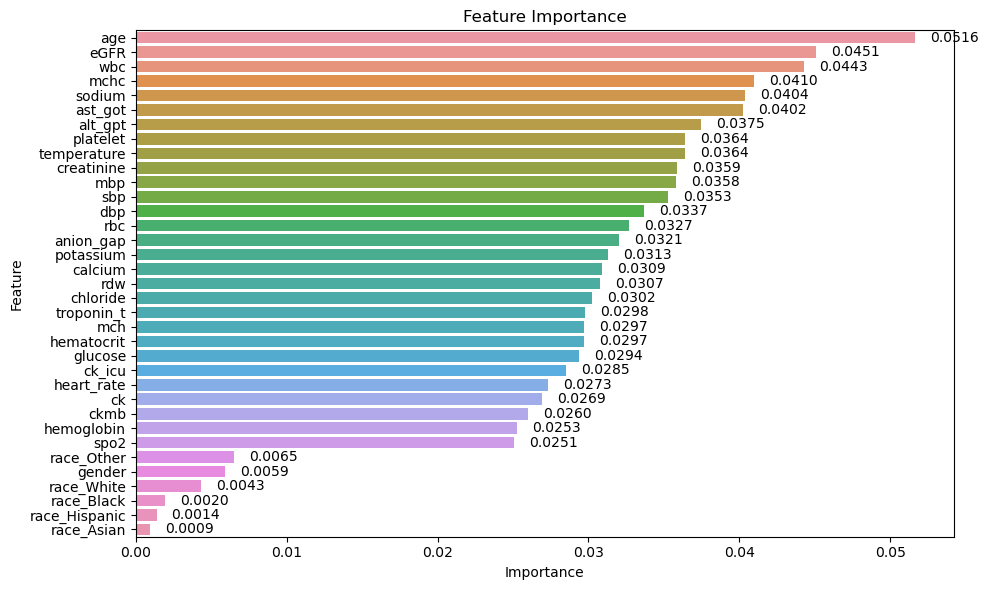

In [142]:
# Step 11: Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# 設定畫布大小
plt.figure(figsize=(10, 6))

# 畫出特徵重要性圖
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

# 在每個條形圖上方顯示數值
for i, v in enumerate(feature_importance_df['Importance']):
    ax.text(v + 0.001, i, f'{v:.4f}', va='center')

# 設置標題和軸標籤
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# 顯示圖表
plt.tight_layout()
plt.show()


In [148]:
# Create a function to evaluate model performance for a specific race
def evaluate_performance_by_race(race_column_name, race_label):
    # Filter the test set by race
    race_mask = X_test[race_column_name] == race_label
    X_test_race = X_test[race_mask]
    y_test_race = y_test[race_mask]

    # 印出該種族的資料筆數
    print(f"\nNumber of samples for {race_column_name}: {len(X_test_race)}")

    # Predict on this subset of the test set
    y_test_pred_race = rf_model.predict(X_test_race)

    # Evaluate metrics for this race subset
    accuracy_race = accuracy_score(y_test_race, y_test_pred_race)
    precision_race = precision_score(y_test_race, y_test_pred_race)
    recall_race = recall_score(y_test_race, y_test_pred_race)

    print(f"Performance for {race_column_name}:")
    print(f"Accuracy: {accuracy_race:.4f}")
    print(f"Precision: {precision_race:.4f}")
    print(f"Recall: {recall_race:.4f}")

# Assuming that race has been one-hot encoded, adjust for the column names
races = ['race_Asian', 'race_Black', 'race_Hispanic', 'race_Other', 'race_White']

# Evaluate performance for each race
for race in races:
    evaluate_performance_by_race(race_column_name=race, race_label=1)  # '1' in one-hot encoded columns indicates belonging to that race



Number of samples for race_Asian: 11
Performance for race_Asian:
Accuracy: 0.6364
Precision: 0.0000
Recall: 0.0000

Number of samples for race_Black: 38
Performance for race_Black:
Accuracy: 0.8421
Precision: 0.7500
Recall: 0.3750

Number of samples for race_Hispanic: 12
Performance for race_Hispanic:
Accuracy: 0.6667
Precision: 0.5000
Recall: 0.2500

Number of samples for race_Other: 87
Performance for race_Other:
Accuracy: 0.8506
Precision: 0.9091
Recall: 0.4545

Number of samples for race_White: 296
Performance for race_White:
Accuracy: 0.7804
Precision: 0.8095
Recall: 0.2179


In [149]:
# Create a function to evaluate model performance by gender
def evaluate_performance_by_gender(gender_label):
    # Filter the test set by gender
    gender_mask = X_test['gender'] == gender_label
    X_test_gender = X_test[gender_mask]
    y_test_gender = y_test[gender_mask]

    # 印出該性別的資料筆數
    print(f"\nNumber of samples for gender {gender_label}: {len(X_test_gender)}")

    # Predict on this subset of the test set
    y_test_pred_gender = rf_model.predict(X_test_gender)

    # Evaluate metrics for this gender subset
    accuracy_gender = accuracy_score(y_test_gender, y_test_pred_gender)
    precision_gender = precision_score(y_test_gender, y_test_pred_gender)
    recall_gender = recall_score(y_test_gender, y_test_pred_gender)

    print(f"Performance for gender {gender_label}:")
    print(f"Accuracy: {accuracy_gender:.4f}")
    print(f"Precision: {precision_gender:.4f}")
    print(f"Recall: {recall_gender:.4f}")

# Evaluate performance for both genders (0: Female, 1: Male)
genders = [0, 1]

# Evaluate performance for each gender
for gender in genders:
    evaluate_performance_by_gender(gender_label=gender)



Number of samples for gender 0: 171
Performance for gender 0:
Accuracy: 0.7895
Precision: 0.8000
Recall: 0.2667

Number of samples for gender 1: 273
Performance for gender 1:
Accuracy: 0.7949
Precision: 0.8261
Recall: 0.2676


In [151]:
# Step 8: Train an XGBoost Classifier using cross-validation on the training set
xgb_model = xgb.XGBClassifier(random_state=42)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Print the accuracy for each fold and the mean accuracy
print("Cross-validation accuracies (5-fold) on training set:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

# Step 9: Fit the model on the full training set
xgb_model.fit(X_train, y_train)

# Step 10: Evaluate the model on the test set
y_test_pred = xgb_model.predict(X_test)

# Evaluate accuracy, precision, and recall on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Precision: {precision:.4f}")
print(f"Test set Recall: {recall:.4f}")

# 保存 XGBoost 模型到本地文件
model_filename = 'xgboost_model.pkl'
joblib.dump(xgb_model, model_filename)

print(f"Model saved to {model_filename}")

Cross-validation accuracies (5-fold) on training set: [0.8056338  0.7915493  0.7943662  0.76271186 0.79661017]
Mean cross-validation accuracy: 0.7902

Test set Accuracy: 0.7613
Test set Precision: 0.5833
Test set Recall: 0.3017
Model saved to xgboost_model.pkl


In [162]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217 entries, 0 to 2216
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            2217 non-null   float64
 1   gender         2217 non-null   float64
 2   hematocrit     2217 non-null   float64
 3   hemoglobin     2217 non-null   float64
 4   platelet       2217 non-null   float64
 5   wbc            2217 non-null   float64
 6   rbc            2217 non-null   float64
 7   mch            2217 non-null   float64
 8   mchc           2217 non-null   float64
 9   rdw            2217 non-null   float64
 10  potassium      2217 non-null   float64
 11  troponin_t     2217 non-null   float64
 12  ck             2217 non-null   float64
 13  ck_icu         2217 non-null   float64
 14  ckmb           2217 non-null   float64
 15  ast_got        2217 non-null   float64
 16  alt_gpt        2217 non-null   float64
 17  calcium        2217 non-null   float64
 18  sodium  

In [189]:
df_tmu = pd.read_csv("tmu_mi_mortality.csv")
df_tmu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CHR_NO_     795 non-null    object 
 1   SE_TYPE_    795 non-null    int64  
 2   AGE         795 non-null    object 
 3   race        795 non-null    object 
 4   Glucose_AC  372 non-null    float64
 5   BUN         547 non-null    float64
 6   Creatinine  19 non-null     float64
 7   CKB         795 non-null    float64
 8   Troponin-I  762 non-null    object 
 9   WBC         543 non-null    object 
 10  RBC         540 non-null    object 
 11  platelet    519 non-null    object 
 12  CH          515 non-null    float64
 13  CHC         515 non-null    float64
 14  CV          515 non-null    float64
 15  RDW-CV      375 non-null    object 
 16  Neutrophil  486 non-null    object 
 17  Lyphocyte   486 non-null    object 
 18  PT INR      363 non-null    float64
 19  PT          363 non-null    f

In [190]:
# 對應欄位名稱的更改
new_columns = ['subject_id', 'gender', 'age', 'race', 'glucose', 'bun', 'creatinine', 'ckmb', 'troponin_i', 'wbc', 'rbc', 'platelet', 'mch', 'mchc', 'mcv', 'rdw', 'neutrophils', 'lymphocytes', 'pt_inr', 'pt', 'calcium', 'sodium', 'potassium', 'bicarbonate', 'chloride', 'eGFR', 'bnp', 'ntprobnp', 'ast_got', 'alt_gpt', 'label']

# 修改 df_tm 的欄位名稱
df_tmu.columns = new_columns

In [191]:
df_tmu.head()

,subject_id,gender,age,race,glucose,bun,creatinine,ckmb,troponin_i,wbc,...,sodium,potassium,bicarbonate,chloride,eGFR,bnp,ntprobnp,ast_got,alt_gpt,label
0,9B640BB0F12164A9FC453DC07D6D8A1E666697B5969623...,1,47,Asian,248.0,NaN,NaN,9.70,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,9B640BB0F12164A989AF7FED942EAC7A7863636C8AF023...,1,70,Asian,NaN,47.0,NaN,32.28,6.3,10.3,...,142.0,4.5,NaN,NaN,18.2,NaN,NaN,NaN,NaN,0
2,9B640BB0F12164A97630869F9B3468C08359E3D4B0BEEE...,0,50,Asian,NaN,NaN,NaN,249.70,25.12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9B640BB0F12164A9FFB0A66AFB7CDC5C628DD5E6B238B1...,0,73,Asian,132.0,14.0,NaN,32.70,2.69,8.7,...,137.0,3.8,NaN,NaN,79.3,NaN,NaN,NaN,35.0,0
4,9B640BB0F12164A96758AE21FD0BC2449E196D9AC42E57...,1,82,Asian,NaN,30.0,NaN,1.90,0.07,12.7,...,137.0,4.2,22.7,108.0,51.1,540.9,2260,31.0,26.0,0


In [194]:
columns = ['gender', 'age', 'race', 'glucose', 'bun', 'creatinine', 'ckmb', 'troponin_i', 'wbc', 'rbc', 'platelet', 'mch', 'mchc', 'mcv', 'rdw', 'neutrophils', 'lymphocytes', 'pt_inr', 'pt', 'calcium', 'sodium', 'potassium', 'bicarbonate', 'chloride', 'eGFR', 'bnp', 'ntprobnp', 'ast_got', 'alt_gpt']
categorical = ['gender','race']
groupby = 'label'

columns_to_convert = ['age', 'troponin_i', 'wbc', 'rbc', 'platelet', 'rdw', 'neutrophils', 'lymphocytes', 'bnp', 'ntprobnp']

for column in columns_to_convert:
    df_tmu[column] = pd.to_numeric(df_tmu[column], errors='coerce')

table1 = TableOne(df_tmu, groupby = groupby, columns = columns, categorical = categorical, pval = True)
display(table1)

Grouped by label                                                              
                                      Missing           Overall                 0                 1 P-Value
n                                                           795               720                75        
gender, n (%)          0                    0        213 (26.8)        187 (26.0)         26 (34.7)   0.139
                       1                             582 (73.2)        533 (74.0)         49 (65.3)        
age, mean (SD)                              1       65.3 (13.5)       64.4 (13.1)       73.9 (13.9)  <0.001
race, n (%)            Asian                0       795 (100.0)       720 (100.0)        75 (100.0)   1.000
glucose, mean (SD)                        423      143.6 (55.4)      141.9 (53.0)      163.2 (76.4)   0.146
bun, mean (SD)                            248       34.6 (26.5)       32.7 (24.9)       47.6 (33.1)   0.001
creatinine, mean (SD)                     776         2.5 (2.6)         2.5 (2.6)         nan (nan)     nan
ckmb, mean (SD)                             0     108.3 (169.5)     107.1 (168.2)     119.5 (182.4)   0.574
troponin_i, mean (SD)                      34  1327.9 (11671.4)  1457.0 (12258.9)      92.3 (424.4)   0.004
wbc, mean (SD)                            290      79.6 (636.5)      89.2 (680.7)        13.2 (5.7)   0.020
rbc, mean (SD)                            293        5.1 (21.9)         4.1 (2.6)       11.6 (59.0)   0.299
platelet, mean (SD)                       283      210.2 (78.1)      213.6 (77.3)      187.9 (79.6)   0.014
mch, mean (SD)                            280        30.2 (2.9)        30.2 (2.9)        30.1 (3.1)   0.916
mchc, mean (SD)                           280        34.0 (1.2)        34.1 (1.2)        33.7 (1.1)   0.008
mcv, mean (SD)                            280        88.6 (7.1)        88.5 (7.1)        89.0 (7.5)   0.603
rdw, mean (SD)                            795         nan (nan)         nan (nan)         nan (nan)     nan
neutrophils, mean (SD)                    795         nan (nan)         nan (nan)         nan (nan)     nan
lymphocytes, mean (SD)                    795         nan (nan)         nan (nan)         nan (nan)     nan
pt_inr, mean (SD)                         432         1.2 (0.4)         1.1 (0.2)         1.6 (0.8)  <0.001
pt, mean (SD)                             432        14.9 (3.8)        14.2 (2.5)        19.0 (7.2)  <0.001
calcium, mean (SD)                        495         8.4 (0.8)         8.5 (0.8)         8.3 (0.9)   0.187
sodium, mean (SD)                         233       137.7 (4.5)       137.7 (4.3)       137.6 (5.6)   0.795
potassium, mean (SD)                      225         3.8 (0.6)         3.8 (0.5)         4.0 (1.0)   0.049
bicarbonate, mean (SD)                    449        21.5 (5.2)        22.1 (4.7)        19.1 (6.5)   0.001
chloride, mean (SD)                       648       103.8 (8.5)       104.1 (7.4)      102.7 (12.2)   0.574
eGFR, mean (SD)                           229       55.8 (39.1)       58.6 (38.7)       36.2 (36.1)  <0.001
bnp, mean (SD)                            661   2581.4 (3171.5)   2565.7 (3189.4)   2653.4 (3154.3)   0.903
ntprobnp, mean (SD)                       652   6880.0 (9527.8)   6607.6 (9432.4)  9041.6 (10316.0)   0.381
ast_got, mean (SD)                        445     137.0 (428.4)      97.0 (262.5)     401.1 (936.7)   0.034
alt_gpt, mean (SD)                        439     102.4 (371.2)      68.6 (213.4)     291.6 (788.3)   0.044

In [195]:
table1.to_csv('tmu_mi_mortality_stat.csv')

In [ ]:
"""for index, row in df_preprocessed.iterrows():
    if row['death_hours_after_in_icu'] < 0:
        print(row['subject_id'])"""

11788649
11622859
14685498
15962265
11801858
19459468
11439927
10509305
16831009
12597933
16145682
11982665
10336220
13188249
10316898
16470044
12136768
15609215
14546615
17759808
